<a href="https://colab.research.google.com/github/kimdain0222/kimdain0222/blob/main/%EB%AA%A8%EB%8D%B834_%EC%B0%90%EC%B5%9C%EC%A2%85.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Import

In [1]:
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
import lightgbm as lgb
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, f1_score
import numpy as np
import time
import warnings
warnings.filterwarnings('ignore')
import kagglehub
path = kagglehub.dataset_download("asjad99/mimiciii")
print(path)
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, roc_curve, roc_auc_score
import matplotlib.pyplot as plt


/kaggle/input/mimiciii


In [2]:
#!pip install --upgrade --force-reinstall torch torchvision torchaudio

In [3]:
df_PATIENTS = pd.read_csv('/kaggle/input/mimiciii/mimic-iii-clinical-database-demo-1.4/PATIENTS.csv')
df_CHARTEVENTS = pd.read_csv('/kaggle/input/mimiciii/mimic-iii-clinical-database-demo-1.4/CHARTEVENTS.csv')
df_ADMISSIONS = pd.read_csv('/kaggle/input/mimiciii/mimic-iii-clinical-database-demo-1.4/ADMISSIONS.csv')
df_D_ITEMS = pd.read_csv('/kaggle/input/mimiciii/mimic-iii-clinical-database-demo-1.4/D_ITEMS.csv')

df_ADMISSIONS = df_ADMISSIONS[df_ADMISSIONS['subject_id'] != 10120]
df_PATIENTS = df_PATIENTS[df_PATIENTS['subject_id'] != 10120]

df_PATIENTS = df_PATIENTS.loc[:,['subject_id','gender']]

# 2. 전처리


In [4]:
df_ADMISSIONS_flag = df_ADMISSIONS.loc[:,['subject_id','hospital_expire_flag']]
df_ADMISSIONS_select = df_ADMISSIONS.loc[:,['subject_id','admission_type','admission_location','discharge_location',
                     'insurance','marital_status','ethnicity','diagnosis','hospital_expire_flag']]
df_ADMISSIONS_select_s = pd.merge(df_PATIENTS, df_ADMISSIONS_select, on='subject_id', how='left')
df_ADMISSIONS_select_s[df_ADMISSIONS_select_s['hospital_expire_flag'] == 1].iloc[0]

,1
subject_id,10011
gender,F
admission_type,EMERGENCY
admission_location,TRANSFER FROM HOSP/EXTRAM
discharge_location,DEAD/EXPIRED
insurance,Private
marital_status,SINGLE
ethnicity,UNKNOWN/NOT SPECIFIED
diagnosis,HEPATITIS B
hospital_expire_flag,1


# 3. 모델


## 3-1 모든 변수

In [5]:
import torchvision.models as models

# 정적 컬럼 지정
static_cols = [
    'gender', 'admission_type', 'admission_location', 'discharge_location',
    'insurance', 'marital_status', 'ethnicity'
]
target_col = 'hospital_expire_flag'

# 원본 정적 데이터
df_static = df_ADMISSIONS_select_s[static_cols + [target_col]].copy()

# NaN 처리
df_static[static_cols] = df_static[static_cols].fillna('UNKNOWN')

# ✅ One-hot encoding
df_static_encoded = pd.get_dummies(df_static, columns=static_cols)

# 입력과 타겟 분리
X = df_static_encoded.drop(columns=[target_col]).values
y = df_static_encoded[target_col].values

# CNN 입력 형태로 reshape (3, 4, 4)
num_features = X.shape[1]
side_len = int(np.ceil(np.sqrt(num_features)))
pad_len = side_len ** 2 - num_features
X_padded = np.pad(X, ((0, 0), (0, pad_len)), mode='constant')
X_cnn = X_padded.reshape(-1, 1, side_len, side_len)  # (N, 1, H, W)
X_cnn = np.repeat(X_cnn, 3, axis=1)  # ResNet expects 3 channels

# Tensor로 변환
X_tensor = torch.tensor(X_cnn, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

# Train/Val Split
X_train, X_val, y_train, y_val = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

# ResNet 모델
model = models.resnet34(pretrained=False)
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 1),
    nn.Sigmoid()
)

Epoch 1 | Train Loss: 0.7530
Epoch 2 | Train Loss: 0.6884
Epoch 3 | Train Loss: 0.3571
Epoch 4 | Train Loss: 0.5941
Epoch 5 | Train Loss: 0.3642
Epoch 6 | Train Loss: 0.3029
Epoch 7 | Train Loss: 0.1480
Epoch 8 | Train Loss: 0.2023
Epoch 9 | Train Loss: 0.1374
Epoch 10 | Train Loss: 0.0749
Epoch 11 | Train Loss: 0.0605
Epoch 12 | Train Loss: 0.1030
Epoch 13 | Train Loss: 0.0622
Epoch 14 | Train Loss: 0.2514
Epoch 15 | Train Loss: 0.0978
Epoch 16 | Train Loss: 0.2676
Epoch 17 | Train Loss: 0.0833
Epoch 18 | Train Loss: 0.0901
Epoch 19 | Train Loss: 0.1944
Epoch 20 | Train Loss: 0.1525


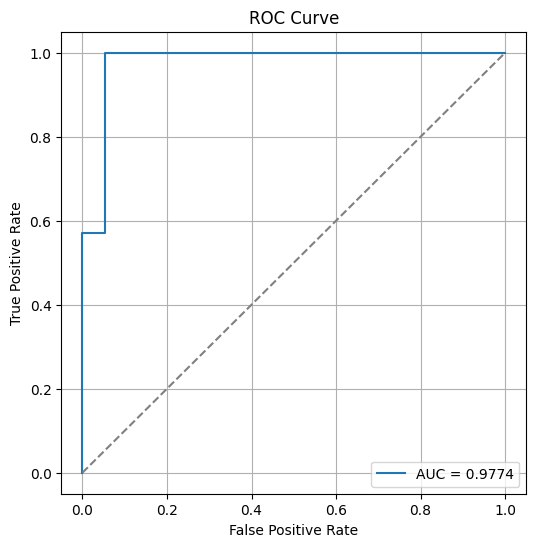

✅ Accuracy: 0.9231
✅ F1 Score: 0.8571


In [6]:
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=16, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=16)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 학습 루프
for epoch in range(20):
    model.train()
    train_loss = 0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        pred = model(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    print(f"Epoch {epoch+1} | Train Loss: {train_loss / len(train_loader):.4f}")

# 검증 데이터로 예측
model.eval()
with torch.no_grad():
    y_pred = model(X_val).numpy()  # 예측 확률
    y_true = y_val.numpy()         # 실제 정답
    y_pred_label = (y_pred > 0.5).astype(int)  # 확률 → 0 또는 1

# 평가 지표 출력
acc = accuracy_score(y_true, y_pred_label)
f1 = f1_score(y_true, y_pred_label)

model.eval()
with torch.no_grad():
    y_pred = model(X_val).numpy()
    y_true = y_val.numpy()
    y_pred_label = (y_pred > 0.5).astype(int)

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
auc = roc_auc_score(y_true, y_pred)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

print(f"✅ Accuracy: {acc:.4f}")
print(f"✅ F1 Score: {f1:.4f}")

# 3-2 퇴원장소 뺴기

In [7]:
import torchvision.models as models

# 정적 컬럼 지정
static_cols = [
    'gender', 'admission_type', 'admission_location',
    'insurance', 'marital_status', 'ethnicity'
]
target_col = 'hospital_expire_flag'

# 원본 정적 데이터
df_static = df_ADMISSIONS_select_s[static_cols + [target_col]].copy()

# NaN 처리
df_static[static_cols] = df_static[static_cols].fillna('UNKNOWN')

# ✅ One-hot encoding
df_static_encoded = pd.get_dummies(df_static, columns=static_cols)

# 입력과 타겟 분리
X = df_static_encoded.drop(columns=[target_col]).values
y = df_static_encoded[target_col].values

# CNN 입력 형태로 reshape (3, 4, 4)
num_features = X.shape[1]
side_len = int(np.ceil(np.sqrt(num_features)))
pad_len = side_len ** 2 - num_features
X_padded = np.pad(X, ((0, 0), (0, pad_len)), mode='constant')
X_cnn = X_padded.reshape(-1, 1, side_len, side_len)  # (N, 1, H, W)
X_cnn = np.repeat(X_cnn, 3, axis=1)  # ResNet expects 3 channels

# Tensor로 변환
X_tensor = torch.tensor(X_cnn, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

# Train/Val Split
X_train, X_val, y_train, y_val = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

# ResNet 모델
model = models.resnet34(pretrained=False)
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 1),
    nn.Sigmoid()
)

Epoch 1 | Train Loss: 0.9291
Epoch 2 | Train Loss: 0.9864
Epoch 3 | Train Loss: 1.0363
Epoch 4 | Train Loss: 0.7379
Epoch 5 | Train Loss: 0.6355
Epoch 6 | Train Loss: 0.5483
Epoch 7 | Train Loss: 0.6018
Epoch 8 | Train Loss: 0.5629
Epoch 9 | Train Loss: 0.6162
Epoch 10 | Train Loss: 0.5556
Epoch 11 | Train Loss: 0.5109
Epoch 12 | Train Loss: 0.6207
Epoch 13 | Train Loss: 0.4932
Epoch 14 | Train Loss: 0.6096
Epoch 15 | Train Loss: 0.5740
Epoch 16 | Train Loss: 0.5216
Epoch 17 | Train Loss: 0.5655
Epoch 18 | Train Loss: 0.4980
Epoch 19 | Train Loss: 0.6494
Epoch 20 | Train Loss: 0.5329


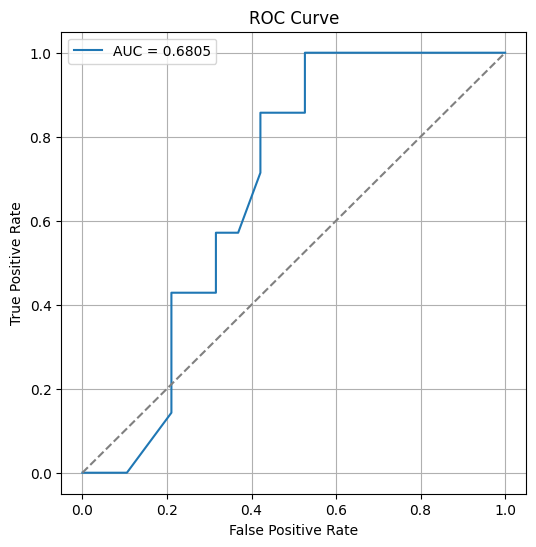

✅ Accuracy: 0.6538
✅ F1 Score: 0.3077


In [8]:
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=16, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=16)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 학습 루프
for epoch in range(20):
    model.train()
    train_loss = 0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        pred = model(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    print(f"Epoch {epoch+1} | Train Loss: {train_loss / len(train_loader):.4f}")

# 검증 데이터로 예측
model.eval()
with torch.no_grad():
    y_pred = model(X_val).numpy()  # 예측 확률
    y_true = y_val.numpy()         # 실제 정답
    y_pred_label = (y_pred > 0.5).astype(int)  # 확률 → 0 또는 1

# 평가 지표 출력
acc = accuracy_score(y_true, y_pred_label)
f1 = f1_score(y_true, y_pred_label)

model.eval()
with torch.no_grad():
    y_pred = model(X_val).numpy()
    y_true = y_val.numpy()
    y_pred_label = (y_pred > 0.5).astype(int)

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
auc = roc_auc_score(y_true, y_pred)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

print(f"✅ Accuracy: {acc:.4f}")
print(f"✅ F1 Score: {f1:.4f}")

# 3-3 gender 제외


In [15]:
import torchvision.models as models

# 정적 컬럼 지정
static_cols = [
    'gender', 'admission_type', 'admission_location', 'discharge_location',
    'insurance', 'marital_status', 'ethnicity'
]
target_col = 'hospital_expire_flag'

# 원본 정적 데이터
df_static = df_ADMISSIONS_select_s[static_cols + [target_col]].copy()

# NaN 처리
df_static[static_cols] = df_static[static_cols].fillna('UNKNOWN')

# ✅ One-hot encoding
df_static_encoded = pd.get_dummies(df_static, columns=static_cols)

# 입력과 타겟 분리
X = df_static_encoded.drop(columns=[target_col]).values
y = df_static_encoded[target_col].values

# CNN 입력 형태로 reshape (3, 4, 4)
num_features = X.shape[1]
side_len = int(np.ceil(np.sqrt(num_features)))
pad_len = side_len ** 2 - num_features
X_padded = np.pad(X, ((0, 0), (0, pad_len)), mode='constant')
X_cnn = X_padded.reshape(-1, 1, side_len, side_len)  # (N, 1, H, W)
X_cnn = np.repeat(X_cnn, 3, axis=1)  # ResNet expects 3 channels

# Tensor로 변환
X_tensor = torch.tensor(X_cnn, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

# Train/Val Split
X_train, X_val, y_train, y_val = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

# ResNet 모델
model = models.resnet34(pretrained=False)
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 1),
    nn.Sigmoid()
)

Epoch 1 | Train Loss: 0.7598
Epoch 2 | Train Loss: 0.6873
Epoch 3 | Train Loss: 0.5852
Epoch 4 | Train Loss: 0.3615
Epoch 5 | Train Loss: 0.2252
Epoch 6 | Train Loss: 0.1740
Epoch 7 | Train Loss: 0.0233
Epoch 8 | Train Loss: 0.1047
Epoch 9 | Train Loss: 0.2071
Epoch 10 | Train Loss: 0.1081
Epoch 11 | Train Loss: 0.3371
Epoch 12 | Train Loss: 0.1926
Epoch 13 | Train Loss: 0.2745
Epoch 14 | Train Loss: 0.0943
Epoch 15 | Train Loss: 0.0318
Epoch 16 | Train Loss: 0.1378
Epoch 17 | Train Loss: 0.1814
Epoch 18 | Train Loss: 0.0671
Epoch 19 | Train Loss: 0.2789
Epoch 20 | Train Loss: 0.0659


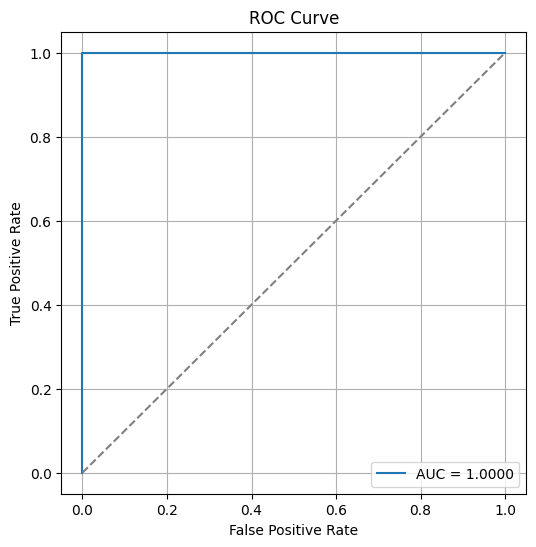

✅ Accuracy: 1.0000
✅ F1 Score: 1.0000


In [16]:
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=16, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=16)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 학습 루프
for epoch in range(20):
    model.train()
    train_loss = 0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        pred = model(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    print(f"Epoch {epoch+1} | Train Loss: {train_loss / len(train_loader):.4f}")

# 검증 데이터로 예측
model.eval()
with torch.no_grad():
    y_pred = model(X_val).numpy()  # 예측 확률
    y_true = y_val.numpy()         # 실제 정답
    y_pred_label = (y_pred > 0.5).astype(int)  # 확률 → 0 또는 1

# 평가 지표 출력
acc = accuracy_score(y_true, y_pred_label)
f1 = f1_score(y_true, y_pred_label)

model.eval()
with torch.no_grad():
    y_pred = model(X_val).numpy()
    y_true = y_val.numpy()
    y_pred_label = (y_pred > 0.5).astype(int)

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
auc = roc_auc_score(y_true, y_pred)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

print(f"✅ Accuracy: {acc:.4f}")
print(f"✅ F1 Score: {f1:.4f}")

In [11]:
X_cnn[0,:,:,:][0].astype(np.float32)

array([[1., 0., 0., 1., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

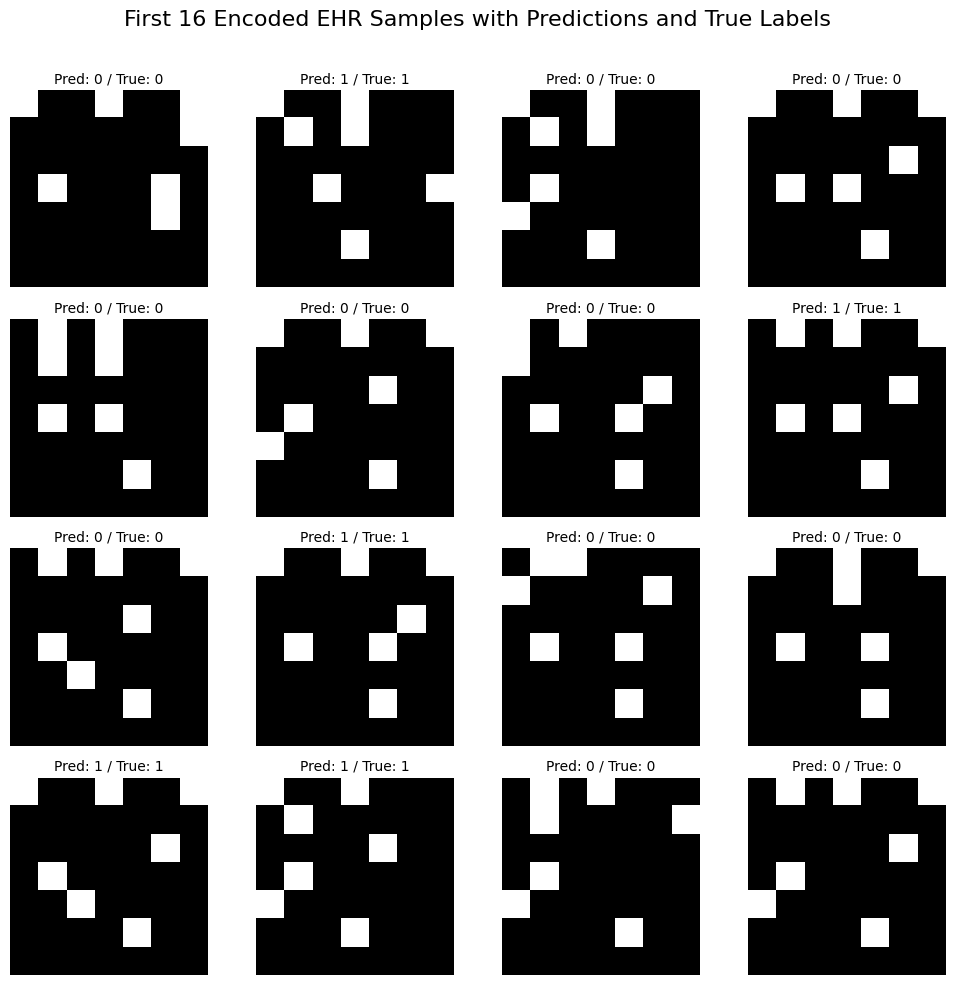

In [12]:
def plot_cnn_inputs_with_labels(X_cnn, y_pred, y_true):
    images = X_cnn[:16]
    preds = y_pred[:16]
    trues = y_true[:16]

    fig, axes = plt.subplots(4, 4, figsize=(10, 10))
    fig.suptitle("First 16 Encoded EHR Samples with Predictions and True Labels", fontsize=16)

    for i, ax in enumerate(axes.flat):
        img = images[i].astype(np.float32)
        img /= (np.max(img) + 1e-8)
        ax.imshow(np.transpose(img, (1, 2, 0)), interpolation='nearest')
        ax.axis("off")

        ax.set_title(f"Pred: {int(preds[i])} / True: {int(trues[i])}", fontsize=10, pad=5)

    plt.tight_layout()
    plt.subplots_adjust(top=0.90)
    plt.show()

plot_cnn_inputs_with_labels(X_cnn,y_pred_label,y_true)